In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import wilcoxon, binomtest
from active_learning import plotting, get_tracked_lineages_df, get_earliest_dates

%config InlineBackend.figure_format = 'svg'

In [3]:
settings = utils.load_settings(path="../settings_sample.json")
cleaned_data_dir = settings["cleaned_data_dir"]
plots_dir = settings["plots_dir"]
reports_dir = settings["reports_dir"]
features_dir = settings["features_dir"]
start_date = settings["detection_start_date"]
n_days_delta = settings["detection_step"]

In [4]:
long_qs2_short = {
    "margin_sampling": "ms",
    "least_confident": "lc",
    "entropy": "en",
}

In [5]:
df = pd.read_parquet(os.path.join(cleaned_data_dir, "cleaned_dataset.parquet"))
df.drop(columns=["Accession ID", "col_date", "sub_date", 'country'], inplace=True)

In [ ]:
detection_files = [x for x in os.listdir(os.path.join(reports_dir, "detection")) if x.endswith('.tsv') and '_detection_dates_' in x]

In [12]:
def get_model_detection_dates(feature:str, query_strategy:str, dump_dir:str, correct_dates:bool=False):
    assert query_strategy in ['least_confident', 'margin_sampling', 'entropy'], f"Invalid query strategy: {query_strategy}"
    assert feature in ['kmer_5', 'kmer_6', 'kmer_7', 'kmer_8', 'fcgr_64', 'fcgr_128', 'murugaiah'], f"Invalid feature: {feature}"

    file_path = os.path.join(dump_dir, "detection", f'{feature}_detection_dates_{query_strategy}.tsv')
    if os.path.exists(file_path):
        model_dates = pd.read_csv(file_path, sep='\t')
        model_dates['model_date'] = pd.to_datetime(model_dates['model_date'])
        if correct_dates:
            model_dates['model_date'] = model_dates['model_date'] + pd.Timedelta(days=n_days_delta)
        model_dates.rename(columns={'model_date': f'{feature}_{long_qs2_short[query_strategy]}'}, inplace=True)
        return model_dates
    else:
        print(f"File not found: {file_path}")

In [14]:
for file in detection_files:
    keys = file.split('_detection_dates_')
    feature, query_strategy = keys[0], keys[1].split('.')[0]
    model_dates = get_model_detection_dates(feature, query_strategy, reports_dir, correct_dates=True)
    if model_dates is not None:
        if 'model_detection_dates_df' not in locals():
            model_detection_dates_df = model_dates
        else:
            model_detection_dates_df = model_detection_dates_df.merge(model_dates, on='lineage', how='outer')

In [10]:
model_detection_dates_df 

,lineage,kmer_7_lc,kmer_7_en,kmer_8_lc,kmer_8_en,fcgr_128_lc,kmer_8_ms,kmer_6_en,murugaiah_en,kmer_7_ms,...,kmer_6_lc,fcgr_64_lc,kmer_5_lc,murugaiah_lc,kmer_5_en,fcgr_64_en,fcgr_64_ms,kmer_6_ms,murugaiah_ms,kmer_5_ms
0,B.1.1.7,2020-09-15,2020-09-15,2020-09-20,2020-09-15,2020-09-15,2020-09-20,2020-09-15,2020-09-15,2020-09-20,...,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-20,2020-09-15,2020-09-20
1,B.1.1.7.4,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2021-03-24,NaT,NaT,NaT
2,B.1.1.7.7,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,B.1.351,2020-05-23,2020-06-02,2020-05-23,2020-05-23,2020-05-23,2020-05-23,2020-05-23,2020-10-20,2020-05-23,...,2020-05-23,2020-05-23,2020-06-02,2020-10-20,2020-06-02,2020-05-23,2020-06-02,2020-06-02,2020-10-10,2020-08-11
4,B.1.351.2,2021-08-06,NaT,2021-08-06,NaT,NaT,2021-01-08,NaT,NaT,2021-01-08,...,NaT,NaT,NaT,2021-04-13,NaT,NaT,2021-01-08,2021-01-08,2021-01-18,2021-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,B.1.526,NaT,2021-03-29,NaT,2021-03-29,NaT,NaT,2021-03-29,2021-03-29,NaT,...,NaT,2021-03-29,NaT,NaT,2021-03-29,2021-03-29,NaT,NaT,NaT,NaT
230,B.1.617.1,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-04-18,2021-03-19,...,2021-03-19,2021-03-19,2021-03-19,2021-04-18,2021-03-19,2021-03-19,2021-04-18,2021-03-19,2021-04-18,2021-03-19
231,B.1.617.3,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,...,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23
232,B.1.1.28.2,NaT,2021-01-18,NaT,2021-01-18,NaT,NaT,2021-01-18,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2021-02-27,NaT,2021-02-27


In [11]:
vois_df = get_tracked_lineages_df(df)
designation_dates = vois_df[['lineage', 'who_label', 'count', 'designation_date', 'first_dataset_date']]

In [12]:
merged_df = pd.merge(designation_dates, model_detection_dates_df, on='lineage', how='left')

In [13]:
merged_df

,lineage,who_label,count,designation_date,first_dataset_date,kmer_7_lc,kmer_7_en,kmer_8_lc,kmer_8_en,fcgr_128_lc,...,kmer_6_lc,fcgr_64_lc,kmer_5_lc,murugaiah_lc,kmer_5_en,fcgr_64_en,fcgr_64_ms,kmer_6_ms,murugaiah_ms,kmer_5_ms
0,B.1.1.7,Alpha,2471,2020-12-29,2020-09-16,2020-09-15,2020-09-15,2020-09-20,2020-09-15,2020-09-15,...,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-20,2020-09-15,2020-09-20
1,B.1.1.7.7,Alpha,1,2020-12-29,2020-09-16,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,B.1.1.7.4,Alpha,4,2020-12-29,2020-09-16,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2021-03-24,NaT,NaT,NaT
3,B.1.351,Beta,5330,2020-12-29,2020-02-18,2020-05-23,2020-06-02,2020-05-23,2020-05-23,2020-05-23,...,2020-05-23,2020-05-23,2020-06-02,2020-10-20,2020-06-02,2020-05-23,2020-06-02,2020-06-02,2020-10-10,2020-08-11
4,B.1.351.2,Beta,1714,2020-12-29,2020-02-18,2021-08-06,NaT,2021-08-06,NaT,NaT,...,NaT,NaT,NaT,2021-04-13,NaT,NaT,2021-01-08,2021-01-08,2021-01-18,2021-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,B.1.526,Iota,1,2021-02-26,2021-03-31,NaT,2021-03-29,NaT,2021-03-29,NaT,...,NaT,2021-03-29,NaT,NaT,2021-03-29,2021-03-29,NaT,NaT,NaT,NaT
241,B.1.617.1,Kappa,5,2021-05-07,2021-03-21,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,...,2021-03-19,2021-03-19,2021-03-19,2021-04-18,2021-03-19,2021-03-19,2021-04-18,2021-03-19,2021-04-18,2021-03-19
242,B.1.617.3,N/A,4,2021-05-07,2021-04-28,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,...,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23
243,B.1.1.28.2,Zeta,3,2021-02-26,2021-01-20,NaT,2021-01-18,NaT,2021-01-18,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2021-02-27,NaT,2021-02-27


In [141]:
target_cols = [x for x in merged_df.columns if 'kmer' in x or 'fcgr' in x or 'murugaiah' in x]
target_cols = sorted(target_cols)

In [142]:
def get_aggegation_dict(kind:str):
    assert kind in ['min', 'max'], f"Invalid kind: {kind}"
    aggregation_dict = {target: kind for target in target_cols}
    aggregation_dict['designation_date'] = kind
    aggregation_dict['first_dataset_date'] = kind
    return aggregation_dict

In [143]:
min_summary_merged_df = merged_df.groupby('who_label').agg(get_aggegation_dict('min')).reset_index()
min_summary_merged_df = min_summary_merged_df.reindex(sorted(min_summary_merged_df.columns), axis=1)

max_summary_merged_df = merged_df.groupby('who_label').agg(get_aggegation_dict('max')).reset_index()
max_summary_merged_df = max_summary_merged_df.reindex(sorted(max_summary_merged_df.columns), axis=1)

In [144]:
earliest_dates = get_earliest_dates()

In [145]:
min_summary_merged_df = min_summary_merged_df.merge(earliest_dates, on='who_label', how='left')


In [146]:
min_summary_merged_df

,designation_date,fcgr_128_en,fcgr_128_lc,fcgr_128_ms,fcgr_64_en,fcgr_64_lc,fcgr_64_ms,first_dataset_date,kmer_5_en,kmer_5_lc,...,kmer_7_lc,kmer_7_ms,kmer_8_en,kmer_8_lc,kmer_8_ms,murugaiah_en,murugaiah_lc,murugaiah_ms,who_label,earliest_date
0,2020-12-29,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-15,2020-09-20,2020-09-16,2020-09-15,2020-09-15,...,2020-09-15,2020-09-20,2020-09-15,2020-09-20,2020-09-20,2020-09-15,2020-09-15,2020-09-15,Alpha,2020-01-19
1,2020-12-29,2020-05-23,2020-05-23,2020-05-23,2020-05-23,2020-05-23,2020-06-02,2020-02-18,2020-06-02,2020-06-02,...,2020-05-23,2020-05-23,2020-05-23,2020-05-23,2020-05-23,2020-10-20,2020-10-20,2020-10-10,Beta,2020-02-18
2,2021-06-15,2020-06-17,2020-06-17,2020-09-05,2020-06-17,2020-06-17,2020-09-05,2020-06-19,2020-06-17,2020-06-17,...,2020-06-17,2020-09-05,2020-06-17,2020-06-17,2020-06-17,2020-09-15,2020-09-15,2020-11-04,Delta,2020-03-24
3,2021-02-26,2021-02-02,2021-02-02,NaT,2021-02-02,2021-02-02,NaT,2021-02-05,2021-02-02,2021-02-02,...,2021-02-02,NaT,2021-02-02,NaT,NaT,NaT,2021-02-02,NaT,Epsilon,2020-01-26
4,2021-02-26,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-20,2020-05-18,2020-05-18,...,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2020-05-18,2021-02-17,2021-01-28,2020-12-09,Eta,2020-03-25
5,2020-12-29,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-22,2021-03-19,2021-03-19,...,NaT,NaT,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,Gamma,2020-04-05
6,2021-02-26,2021-03-29,NaT,NaT,2021-03-29,2021-03-29,NaT,2021-03-31,2021-03-29,NaT,...,NaT,NaT,2021-03-29,NaT,NaT,2021-03-29,NaT,NaT,Iota,2020-01-28
7,2021-05-07,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-04-18,2021-03-21,2021-03-19,2021-03-19,...,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-03-19,2021-04-18,2021-04-18,2021-04-18,Kappa,2020-03-03
8,2021-09-21,2021-07-02,2021-07-02,NaT,2021-07-02,NaT,NaT,2021-07-04,2021-07-02,NaT,...,NaT,NaT,2021-07-02,NaT,NaT,NaT,NaT,NaT,Mu,2020-09-19
9,2021-05-07,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-28,2021-04-23,2021-04-23,...,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,2021-04-23,N/A,2021-01-03


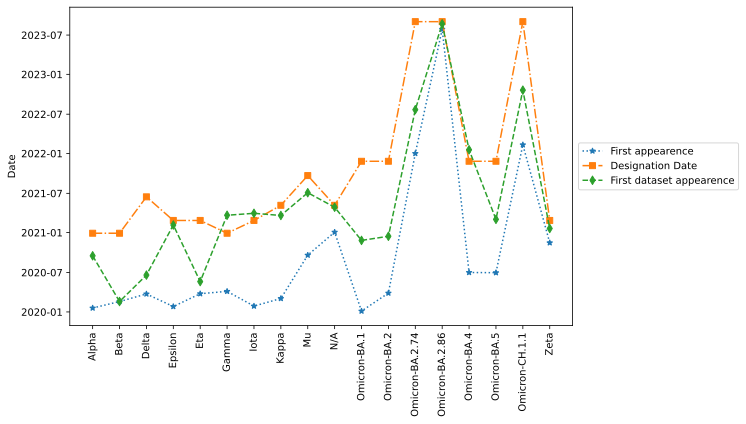

In [147]:
plt.figure(figsize=(11, 6))
cmap = mpl.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(min_summary_merged_df.columns[1:])))

plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['earliest_date'], marker='*', linestyle=':', label='First appearence')
plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['designation_date'], marker='s', linestyle='-.', label='Designation Date')
plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['first_dataset_date'], marker='d', linestyle='--', label='First dataset appearence')

plt.ylabel('Date')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'variants-dates.png'), dpi=600, format='png')


In [149]:
# Plotting
# plt.figure(figsize=(11, 6))
# cmap = mpl.colormaps.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, len(min_summary_merged_df.columns[1:])))

# plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df['designation_date'], marker='s', linestyle='-.', label='Designation Date')

# for i, col in enumerate(model_detection_dates_df.columns[1:]):
#     plt.plot(min_summary_merged_df['who_label'], min_summary_merged_df[col], marker='o', linestyle='-', label=col, color=colors[i])
#     # plt.plot(max_summary_merged_df['who_label'], max_summary_merged_df[col], marker='*', linestyle='-', label=col)
#     # plt.fill_between(min_summary_merged_df['who_label'], min_summary_merged_df[col], max_summary_merged_df[col], color='gray', alpha=0.15)

# # plt.xlabel('WHO Label')
# plt.ylabel('Date')
# # plt.title('Earliest Model date VS Designation Date for Each WHO Label')
# plt.xticks(rotation=40)

# plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
# plt.tight_layout()

# plt.savefig(os.path.join(plots_dir, 'earliest_model_date_vs_designation_date.png'), dpi=600)

In [150]:
uncertainty_measures = ['lc', 'en', 'ms']
measure_to_name = {
    'lc': 'Least Confident',
    'en': 'Entropy',
    'ms': 'Margin Sampling'
}

features = ['kmer_5', 'kmer_6', 'kmer_7', 'kmer_8', 'fcgr_64', 'fcgr_128', 'murugaiah']

def get_label(col:str):
    if 'kmer_5' in col: return '5-mers'
    if 'kmer_6' in col: return '6-mers'
    if 'kmer_7' in col: return '7-mers'
    if 'kmer_8' in col: return '8-mers'
    if 'fcgr_64' in col: return 'FCGR-64'
    if 'fcgr_128' in col: return 'FCGR-128'
    if 'murugaiah' in col: return 'Murugaiah'

In [151]:
def plot_all_simulation_results(results_df, save=True):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, measure in enumerate(uncertainty_measures):
        ax = axs[i]
        ax.plot(results_df['who_label'], results_df['designation_date'], marker='s', linestyle='-.', label='Designation Date')
        ax.plot(results_df['who_label'], results_df['first_dataset_date'], marker='d', linestyle='--', label='Dataset Appearence')
        for col in results_df.columns[1:]:
            if measure in col:
                ax.plot(results_df['who_label'], results_df[col], marker='o', linestyle='-', label=get_label(col))
        
        # ax.set_xlabel('WHO Label')
        ax.set_title(f'{measure_to_name[measure]} dates')
        ax.tick_params(axis='x', rotation=75)

    # axs[0].set_ylabel('Date')
    # fig.suptitle('Detection Dates by WHO Label and Uncertainty Measure')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Features')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        fig.savefig(os.path.join(plots_dir, 'models_vs_designation_date.png'), dpi=600)


def plot_simulation_results(results_df, measure, save=True):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 9))
    axes = axes.flatten()
    handles, labels = [], []

    for i, ax in enumerate(axes):
        ax = axes[i]

        if i >= len(features):
            ax.legend(handles, labels, loc='best')
            break
        
        col = features[i] + f'_{measure}'
        ax.plot(results_df['who_label'], results_df['earliest_date'], marker='*', linestyle=':', label='First appearence')
        ax.plot(results_df['who_label'], results_df['first_dataset_date'], marker='d', linestyle='--', label='First appearence in dataset')
        ax.plot(results_df['who_label'], results_df['designation_date'], marker='s', linestyle='-.', label='Official designation date')
        ax.plot(results_df['who_label'], results_df[col], marker='o', linestyle='-', label='Feature')
        ax.grid(True)
        ax.set_title(get_label(col), fontsize=9)
        ax.xaxis.set_ticks(results_df['who_label'])
        ax.set_xticklabels(results_df['who_label'], rotation=45, ha='right', fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.legend().set_visible(False)

        if i == len(features) - 1:
            for handle, label in zip(*ax.get_legend_handles_labels()):
                handles.append(handle)
                labels.append(label)

    for i in range(len(features), len(axes)):
        # fig.delaxes(axes[i])
        axes[i].axis('off')
    
    fig.suptitle(f'Simulation with the {measure_to_name[measure]} uncertainty measure')
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    if save:
        fig.savefig(os.path.join(plots_dir, f'models_vs_designation_date_{measure}.png'), dpi=600)

In [152]:
# plot_all_simulation_results(min_summary_merged_df, save=True)

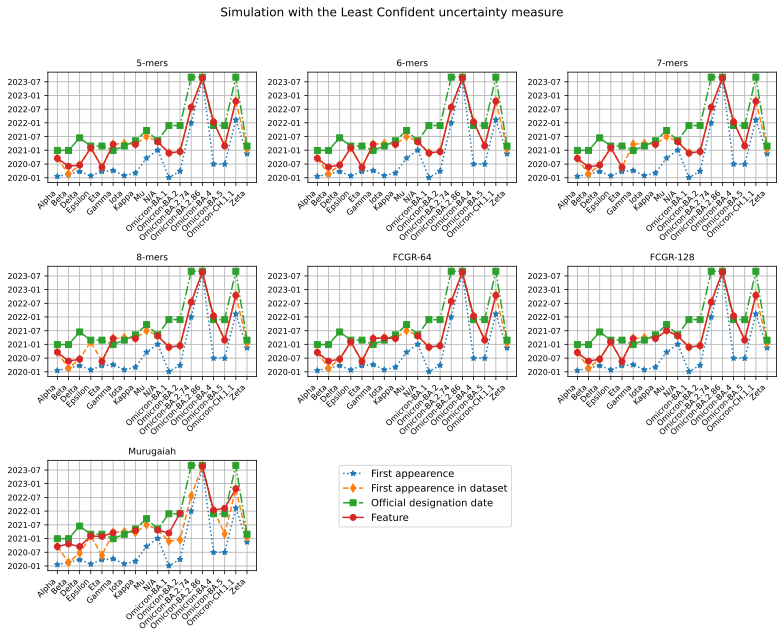

In [153]:
plot_simulation_results(min_summary_merged_df, 'lc', save=True)

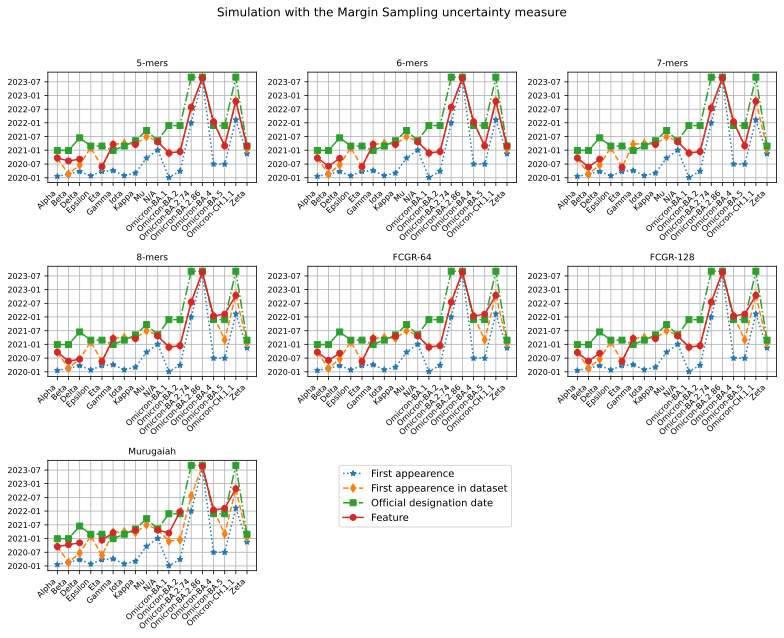

In [154]:
plot_simulation_results(min_summary_merged_df, 'ms', save=True)

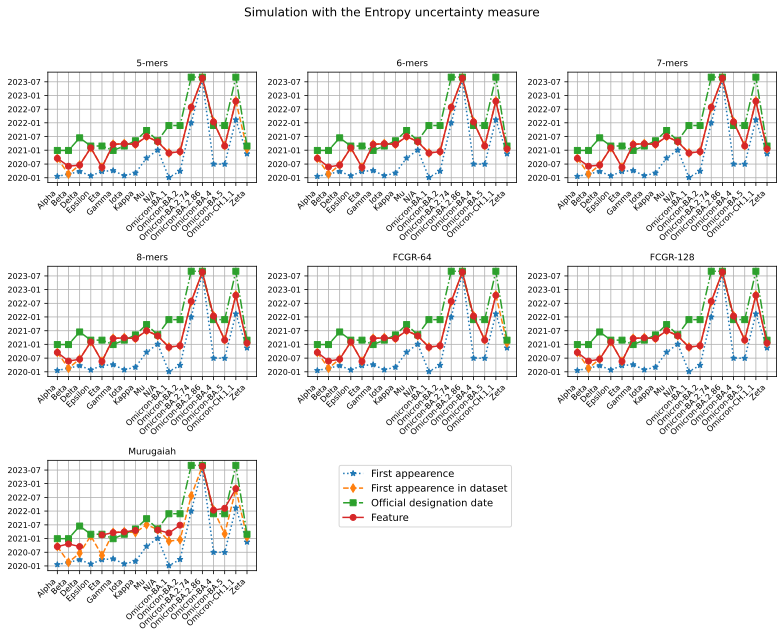

In [155]:
plot_simulation_results(min_summary_merged_df, 'en', save=True)

In [156]:
# # Plotting
# plt.figure(figsize=(11, 6))

# plt.plot(merged_df['lineage'], merged_df['designation_date'], linestyle='-', label='Designation Date', linewidth=2)

# for col in model_detection_dates_df.columns[1:]:
#     plt.plot(merged_df['lineage'], merged_df[col], linestyle='-', label=col)
#     # plt.plot(max_summary_merged_df['who_label'], max_summary_merged_df[col], marker='*', linestyle='-', label=col)
#     # plt.fill_between(min_summary_merged_df['who_label'], min_summary_merged_df[col], max_summary_merged_df[col], color='gray', alpha=0.15)

# plt.xlabel('Lineage')
# plt.ylabel('Date')
# plt.title('Model date VS Designation Date for Each Lineage')
# plt.xticks(rotation=90)

# plt.legend(bbox_to_anchor = (1.34, 0.5), loc='center right')
# plt.tight_layout()

# plt.savefig(os.path.join(plots_dir, 'model_date_vs_designation_date.png'), dpi=300)

In [157]:
min_summary_merged_df.to_excel(os.path.join(reports_dir, 'summary_model_detection_dates_vs_designation_dates.xlsx'), index=False)

In [158]:
merged_df.to_excel(os.path.join(reports_dir, 'model_detection_dates_vs_designation_dates.xlsx'), index=False)

# Detection Lead Time analysis

In [159]:
detection_lt = {}
detection_lt['who_label'] = min_summary_merged_df['who_label']

for target in target_cols:
    detection_lt[target] = ( min_summary_merged_df['designation_date'] - min_summary_merged_df[target]).dt.days

detection_lt_df = pd.DataFrame(detection_lt)

In [160]:
detection_lt_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
who_label,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Mu,N/A,Omicron-BA.1,Omicron-BA.2,Omicron-BA.2.74,Omicron-BA.2.86,Omicron-BA.4,Omicron-BA.5,Omicron-CH.1.1,Zeta
fcgr_128_en,105,220,363,24,284,-80,-31,49,81,14,367,347,401,11,-48,272,321,39
fcgr_128_lc,105.0,220.0,363.0,24.0,284.0,-80.0,NaN,49.0,81.0,14.0,367.0,347.0,411.0,11.0,-48.0,272.0,321.0,NaN
fcgr_128_ms,105.0,220.0,283.0,NaN,284.0,-80.0,NaN,49.0,NaN,14.0,367.0,347.0,411.0,11.0,-48.0,-73.0,321.0,NaN
fcgr_64_en,105.0,220.0,363.0,24.0,284.0,-80.0,-31.0,49.0,81.0,14.0,367.0,347.0,401.0,11.0,-48.0,272.0,321.0,NaN
fcgr_64_lc,105.0,220.0,363.0,24.0,284.0,-80.0,-31.0,49.0,NaN,14.0,367.0,347.0,401.0,11.0,-48.0,272.0,321.0,NaN
fcgr_64_ms,100.0,210.0,283.0,NaN,284.0,-80.0,NaN,19.0,NaN,14.0,367.0,347.0,411.0,11.0,-48.0,-73.0,321.0,NaN
kmer_5_en,105.0,210.0,363.0,24.0,284.0,-80.0,-31.0,49.0,81.0,14.0,367.0,347.0,401.0,11.0,-48.0,272.0,321.0,NaN
kmer_5_lc,105.0,210.0,363.0,24.0,284.0,-80.0,NaN,49.0,NaN,14.0,367.0,347.0,401.0,11.0,-48.0,272.0,321.0,NaN
kmer_5_ms,100.0,140.0,283.0,NaN,274.0,-80.0,NaN,49.0,NaN,14.0,367.0,347.0,401.0,11.0,-48.0,272.0,321.0,-1.0


In [161]:
# Counts negatives per column
(detection_lt_df.drop(['who_label'], axis=1) < 0).sum()

fcgr_128_en     3
fcgr_128_lc     2
fcgr_128_ms     3
fcgr_64_en      3
fcgr_64_lc      3
fcgr_64_ms      3
kmer_5_en       3
kmer_5_lc       2
kmer_5_ms       3
kmer_6_en       3
kmer_6_lc       2
kmer_6_ms       3
kmer_7_en       3
kmer_7_lc       1
kmer_7_ms       1
kmer_8_en       3
kmer_8_lc       2
kmer_8_ms       3
murugaiah_en    4
murugaiah_lc    4
murugaiah_ms    4
dtype: int64

In [162]:
# Counts NaNs (undetected) per column
detection_lt_df.isna().sum()

who_label       0
fcgr_128_en     0
fcgr_128_lc     2
fcgr_128_ms     4
fcgr_64_en      1
fcgr_64_lc      2
fcgr_64_ms      4
kmer_5_en       1
kmer_5_lc       3
kmer_5_ms       3
kmer_6_en       0
kmer_6_lc       3
kmer_6_ms       3
kmer_7_en       0
kmer_7_lc       4
kmer_7_ms       5
kmer_8_en       0
kmer_8_lc       4
kmer_8_ms       4
murugaiah_en    4
murugaiah_lc    4
murugaiah_ms    5
dtype: int64

## Statistic tests for sign check

In [163]:
def wilcoxon_test(df, target:str):
    df_clean = df.dropna(subset=[target])
    stat, p_value = wilcoxon(df_clean[target], alternative='greater')
    
    return stat, p_value

def sign_test(df, target:str, mu0:int=0):
    df_clean = df.dropna(subset=[target])
    pos = df_clean[df_clean[target] > mu0].shape[0]
    neg = df_clean[df_clean[target] < mu0].shape[0]
    M = (pos - neg) / 2.0
    p = binomtest(pos, pos + neg, 0.5, alternative='greater').pvalue
    
    return M, p

In [164]:
tests_results = {"stat": [], "p_value": []}

for target in target_cols:
    stat, p_value = sign_test(detection_lt_df, target)
    tests_results["stat"].append(stat)
    tests_results["p_value"].append(p_value)

tests_results_df = pd.DataFrame(tests_results, index=target_cols)
tests_results_df[['p_value']]

,p_value
fcgr_128_en,0.003769
fcgr_128_lc,0.002090
fcgr_128_ms,0.028687
fcgr_64_en,0.006363
fcgr_64_lc,0.010635
fcgr_64_ms,0.028687
kmer_5_en,0.006363
kmer_5_lc,0.003693
kmer_5_ms,0.017578
kmer_6_en,0.003769


In [165]:
tests_results = {"stat": [], "p_value": []}

for target in target_cols:
    stat, p_value = wilcoxon_test(detection_lt_df, target)
    tests_results["stat"].append(stat)
    tests_results["p_value"].append(p_value)

tests_results_df = pd.DataFrame(tests_results, index=target_cols)
tests_results_df[['p_value']]

,p_value
fcgr_128_en,0.000965
fcgr_128_lc,0.000656
fcgr_128_ms,0.006714
fcgr_64_en,0.001289
fcgr_64_lc,0.002579
fcgr_64_ms,0.008301
kmer_5_en,0.001289
kmer_5_lc,0.001312
kmer_5_ms,0.001678
kmer_6_en,0.000965


## Histogram

In [166]:
all_dlt_np = detection_lt_df.drop(columns=['who_label']).to_numpy().flatten()

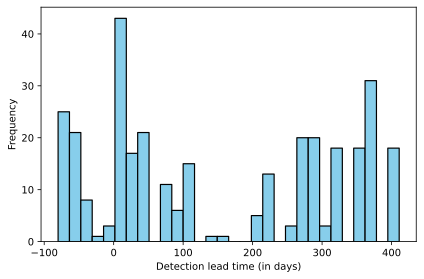

In [167]:
# Histogram
plt.figure(figsize=(6, 4))
plt.hist(all_dlt_np, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Detection lead time (in days)')
plt.ylabel('Frequency')
# plt.title('Histogram of Lag in days between Designation Date and Model Detection Date')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'histogram_lead_time_days.pdf'), dpi=500, format='pdf')

# Time to detection analysis

In [168]:
time_to_detection = {}
time_to_detection['who_label'] = min_summary_merged_df['who_label']

for target in target_cols:
    time_to_detection[target] = (min_summary_merged_df[target] - min_summary_merged_df['first_dataset_date']).dt.days

time_to_detection_df = pd.DataFrame(time_to_detection)

In [169]:
time_to_detection_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
who_label,Alpha,Beta,Delta,Epsilon,Eta,Gamma,Iota,Kappa,Mu,N/A,Omicron-BA.1,Omicron-BA.2,Omicron-BA.2.74,Omicron-BA.2.86,Omicron-BA.4,Omicron-BA.5,Omicron-CH.1.1,Zeta
fcgr_128_en,-1,95,-2,-3,-2,-3,-2,-2,-2,-5,-2,-1,5,-1,-5,-4,-5,-2
fcgr_128_lc,-1.0,95.0,-2.0,-3.0,-2.0,-3.0,NaN,-2.0,-2.0,-5.0,-2.0,-1.0,-5.0,-1.0,-5.0,-4.0,-5.0,NaN
fcgr_128_ms,-1.0,95.0,78.0,NaN,-2.0,-3.0,NaN,-2.0,NaN,-5.0,-2.0,-1.0,-5.0,-1.0,-5.0,341.0,-5.0,NaN
fcgr_64_en,-1.0,95.0,-2.0,-3.0,-2.0,-3.0,-2.0,-2.0,-2.0,-5.0,-2.0,-1.0,5.0,-1.0,-5.0,-4.0,-5.0,NaN
fcgr_64_lc,-1.0,95.0,-2.0,-3.0,-2.0,-3.0,-2.0,-2.0,NaN,-5.0,-2.0,-1.0,5.0,-1.0,-5.0,-4.0,-5.0,NaN
fcgr_64_ms,4.0,105.0,78.0,NaN,-2.0,-3.0,NaN,28.0,NaN,-5.0,-2.0,-1.0,-5.0,-1.0,-5.0,341.0,-5.0,NaN
kmer_5_en,-1.0,105.0,-2.0,-3.0,-2.0,-3.0,-2.0,-2.0,-2.0,-5.0,-2.0,-1.0,5.0,-1.0,-5.0,-4.0,-5.0,NaN
kmer_5_lc,-1.0,105.0,-2.0,-3.0,-2.0,-3.0,NaN,-2.0,NaN,-5.0,-2.0,-1.0,5.0,-1.0,-5.0,-4.0,-5.0,NaN
kmer_5_ms,4.0,175.0,78.0,NaN,8.0,-3.0,NaN,-2.0,NaN,-5.0,-2.0,-1.0,5.0,-1.0,-5.0,-4.0,-5.0,38.0


In [137]:
min_summary_merged_df.columns

Index(['designation_date', 'fcgr_128_en', 'fcgr_128_lc', 'fcgr_128_ms',
       'fcgr_64_en', 'fcgr_64_lc', 'fcgr_64_ms', 'first_dataset_date',
       'kmer_5_en', 'kmer_5_lc', 'kmer_5_ms', 'kmer_6_en', 'kmer_6_lc',
       'kmer_6_ms', 'kmer_7_en', 'kmer_7_lc', 'kmer_7_ms', 'kmer_8_en',
       'kmer_8_lc', 'kmer_8_ms', 'murugaiah_en', 'murugaiah_lc',
       'murugaiah_ms', 'who_label', 'earliest_date'],
      dtype='object')

## Testing plotting and logger

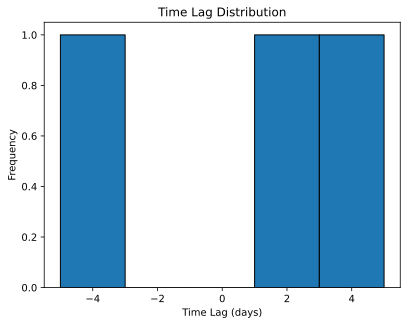

In [35]:
# Histogram
plotting.lags_histogram(
    lags=df['Time Lag'], 
    bins=5, 
    title='Time Lag Distribution', 
    xlabel='Time Lag (days)', 
    ylabel='Frequency',
    save=False,
)

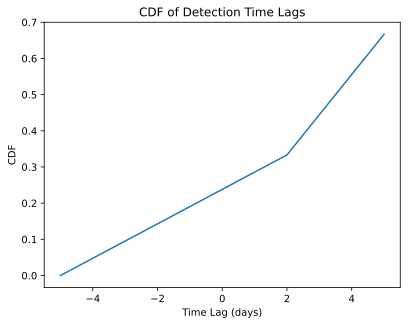

In [36]:
# CDF
plotting.lags_cdf(
    lags=df['Time Lag'], 
    title='CDF of Detection Time Lags', 
    xlabel='Time Lag (days)', 
    ylabel='CDF',
    save=False,
)

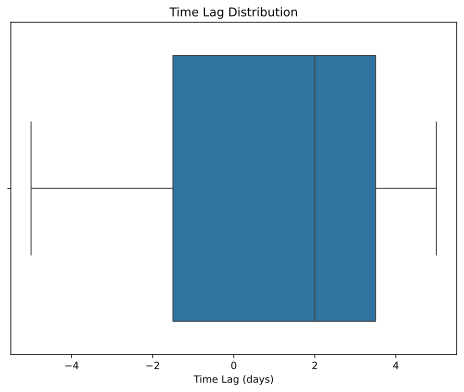

In [37]:
# Box Plot
plotting.lags_boxplot(
    lags=df['Time Lag'], 
    title='Time Lag Distribution', 
    xlabel='Time Lag (days)',
    save=False,
)

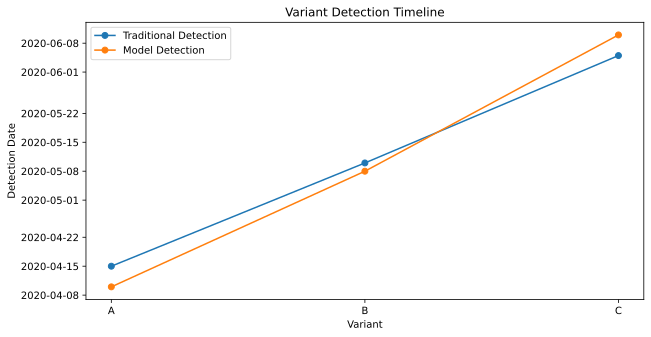

In [40]:
# Time Series Plot
plotting.variants_detection_timeline(
    variants=df['Variant'],
    traditional_detection=df['Traditional'],
    model_detection=df['Model'],
    save=False,
)